In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import json
import preprocess_functions as f

In [10]:
PATH = 'realKnownCause/ec2_request_latency_system_failure.csv'
ERRORPATH = 'labels/combined_labels.json'
df = pd.read_csv(PATH,  parse_dates=['timestamp'])
with open(ERRORPATH, "r") as file:
    error_file = json.load(file)

In [11]:
df.describe()

,timestamp,value
count,4032,4032.000000
mean,2014-03-14 03:40:14.434523648,45.155874
min,2014-03-07 03:41:00,22.864000
25%,2014-03-10 15:39:45,43.944000
50%,2014-03-14 03:38:30,45.017000
75%,2014-03-17 15:42:15,46.362000
max,2014-03-21 03:41:00,99.248000
std,NaN,2.287089


In [12]:
time_diff, df = f.process_time_series(PATH, error_file)
def window_sizes_freq(time_diff):
    window_sizes = dict()
    window_sizes['daily'] = int(60*60*24 / time_diff)
    window_sizes['time_of_day'] = int(window_sizes['daily'] / 4)
    return window_sizes 
window_sizes_freq(time_diff)

{'daily': 288, 'time_of_day': 72}

In [14]:
import stats_helper as helper 

print(helper.seasonality_test(df, 'Additive', 288))
print(helper.seasonality_test(df, 'Additive', 72))

False
False


In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['diff_daily'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}; p-value < 0.05: {result[1] < 0.05}')

ADF Statistic: -5.227580090100702
p-value: 7.72094565871251e-06; p-value < 0.05: True


In [90]:
# Extract the date (ignoring the time part)
df['date'] = df['timestamp'].dt.date

# Now, group by the 'date' and apply the ADF test on each day's data
grouped = df.groupby('date')

for date, data in grouped:
    adf_result = adfuller(data['value'])
    print(f"Date: {date}, ADF p-value: {adf_result[1]}")

,timestamp,value_min_min,value_min_max,value_min_mean
0,2014-07-06 20:00:00,0.064535,0.064535,0.064535
1,2014-07-06 20:15:00,0.063880,0.065692,0.064622
2,2014-07-06 20:30:00,0.056301,0.067751,0.061683
3,2014-07-06 20:45:00,0.000000,0.065288,0.032644
4,2014-07-06 21:00:00,0.000000,0.063179,0.021060


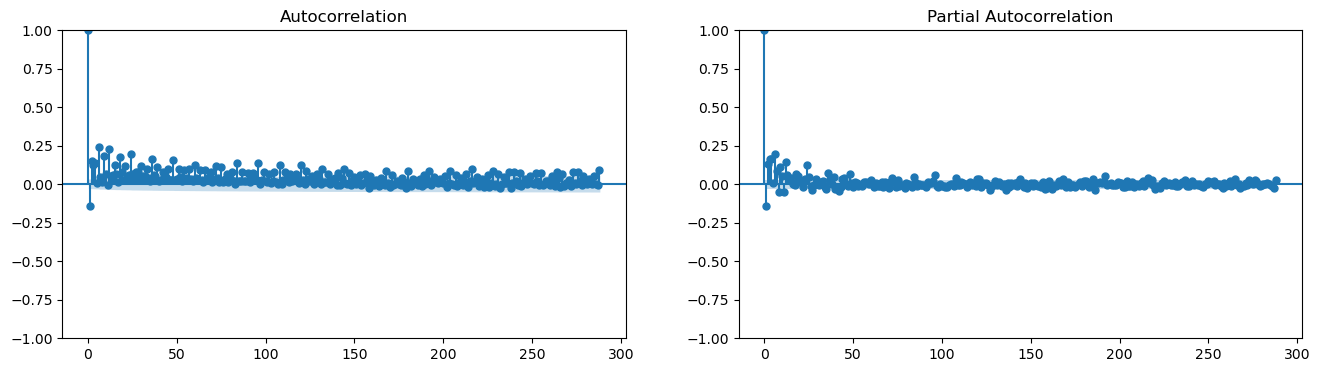

In [11]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(df['value'], lags=288, ax=axes[0])  # Check seasonality
plot_pacf(df['value'], lags=288, ax=axes[1])  # Check short-term dependencies
plt.savefig('images/ec2_acf_pacf.png')
plt.show()

In [115]:
df_30min['outlier'] = df_30min['timestamp'].apply(lambda x: f.is_outlier(x, error_windows))
best_order = auto_model.order
mean_values = df_30min['value_min_mean'].dropna()

In [116]:
from statsmodels.tsa.arima.model import ARIMA

In [20]:
def auto_arima_best_order(params):
    trace      = params['trace'] 
    df         = params['df']
    periods    = params['periods'] 
    
    df      = df[['timestamp', 'value']].dropna()
    model_1  = 'Additive' 
    model_2  = 'Additive' 
    period_1 = periods['time_of_day']
    period_2 = periods['daily']


    # Augmented Dickey-Fuller (ADF) Test
    def adf_test(series):
        if len(series) < 10:  # Ensure at least 10 data points
            return False, False
        result = adfuller(series)
        if result[1] <= 0.05:
            return True, False #print("The series is stationary (reject H0)"), if stationary then trend does not exist
        else:
            return False, True #print("The series is non-stationary (fail to reject H0)")

    def seasonality_test(series, model, period):
        # 2. **Check for Seasonality using Seasonal Decomposition**
        if period < 2 or len(series) < period:
            return False  # Not enough data for decomposition
        try:
            decomposition = seasonal_decompose(series, model=model, period=period)
            seasonal_strength = np.std(decomposition.seasonal) / np.std(series)
            seasonality_present = seasonal_strength > 0.1  # If seasonal component is significant
            return seasonality_present
        except:
            return False  # If decomposition fails, assume no seasonality

    df_stationary, df_trend = adf_test(df['value'])
    df1_seasonality           = seasonality_test(df['value'], model_1, period_1) 
    df2_seasonality           = seasonality_test(df['value'], model_2, period_2)
    
    print(df_stationary, df_trend)
    print(df1_seasonality)
    print(df2_seasonality)

In [21]:
params = {
    'df': df,
    'periods': window_sizes_freq(time_diff),
    'trace': False
}

auto_arima_best_order(params)

True False
False
False


In [15]:
3 == 3 == 3

True